This notebook is used to predict missing Flux-data for Göttingen forest and the forst bothanical garden.  
The approach used is an MLP. Be careful to adjust how many cpu cores u want to use during training!

In [12]:
# important  imports
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import fastprogress

from sklearn.preprocessing import MinMaxScaler


In [13]:
# Get number of cpus to use for faster parallelized data loading
avb_cpus = os.cpu_count()
num_cpus = 4
print(avb_cpus, 'CPUs available,', num_cpus, 'were assigned' )

# Device loader from Deep Learning

######## SPECIFY IF YOU DONT WANT TO USE CUDA (GPU) ###########
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

device = get_device()

8 CPUs available, 4 were assigned
cuda available: False ; cudnn available: False ; num devices: 0
Using device cpu


#  Utilites

In [14]:
############# UTILITIES ############

from modules.util import EBCDataset, grab_data, train_val_test_splitter, data_loaders
from modules.MLPstuff import EarlyStopper

# The Multilayer Perceptron

In [15]:
from modules.MLPstuff import run_training, MLP
from columns import COLS_FEATURES, COLS_LABELS, PATH

# The Training

In [16]:
# Collect data and create data loaders
# if COLS_METEO and COLS_FLUXES are changed make sure to run the preprocessing pipeline first
dataset, num_data, num_labels = grab_data('data/training_data_merged.csv', COLS_FEATURES, COLS_LABELS)

trainset, valset, testset = train_val_test_splitter(dataset)


# normalize features based on trainset statistics only
# trainset_mean = torch.mean(trainset.dataset.dataset.data, dim=0)
# trainset_std = torch.std(trainset.dataset.dataset.data, dim=0)

# trainset.dataset.dataset.data = (trainset.dataset.dataset.data - trainset_mean) / trainset_std ** 2
# valset.dataset.dataset.data = (valset.dataset.dataset.data - trainset_mean) / trainset_std ** 2
# testset.dataset.data = (trainset.dataset.dataset.data - trainset_mean) / trainset_std ** 2

labels_std = torch.std(trainset.dataset.dataset.labels, dim=0)
print(labels_std**2)

trainloader, valloader, testloader = data_loaders(trainset, valset, testset, num_cpus=num_cpus, batch_size=10)

tensor([7081.9624, 4335.7935])


Finished training after 7 seconds.


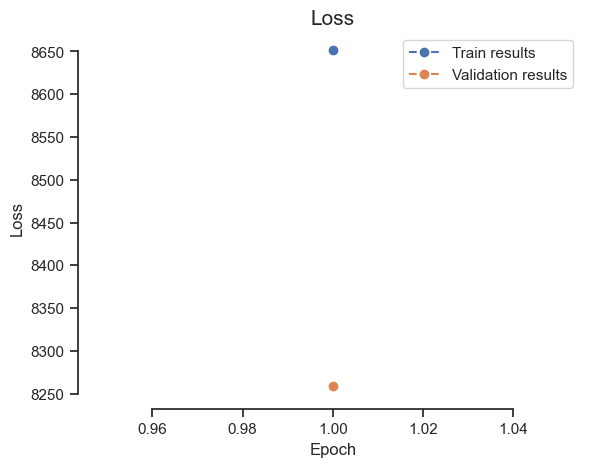

In [17]:
# run single epoch with very low learning rate to check if initial loss is higher than label variance (it should be)
# Initialize the model
model = MLP(num_data, num_labels, num_hidden_units=30, num_hidden_layers=4).to(device)
# Set loss function and optimizer
criterion = nn.MSELoss()
lr = 10**(-5)
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 1

train_losses, val_losses = run_training(model=model, optimizer=optimizer, num_epochs=num_epochs, train_dataloader=trainloader, val_dataloader=valloader, 
                                                              device=device, loss_fn=criterion, patience=5, early_stopper=True, verbose=True)

Train on larger timeframe.

Finished training after 297 seconds.


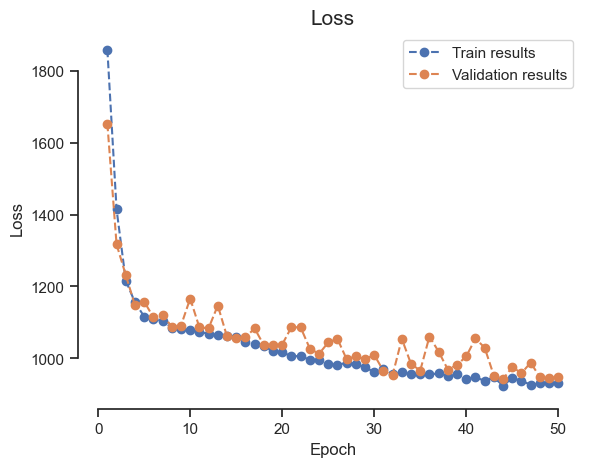

In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the model
model = MLP(num_data, num_labels, num_hidden_units=30, num_hidden_layers=4).to(device)
# Set loss function and optimizer
criterion = nn.MSELoss()
lr = 10**(-3)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10,
                              threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0)

num_epochs = 50

train_losses, val_losses = run_training(model=model, optimizer=optimizer, num_epochs=num_epochs, train_dataloader=trainloader, val_dataloader=valloader, 
                                                              device=device, loss_fn=criterion, patience=5, early_stopper=True, verbose=True)

In [11]:
# Save the model
torch.save(model.state_dict(), 'model_saves/mlp_justus.pth' )